## Upscaling galaxy images using Variational Autoencoders (VAEs)
*Note: This project was originally done for the class [ASTR 31200: Computational Techniques in Astrophysics](http://graduateannouncements.uchicago.edu/graduate/departmentofastronomyandastrophysics/), and has since been adapted as a standalone project.*

Due to the limits of physical telescopes, the resolution of captured images is generally bound by the size of the telescope, though methods exist to reduce error and noise. The purpose of this project is to generate "upscaled" images of galaxies using Variational Autoencoders, which can then be used to test various methods of analyzing galaxies. 

The training and test data sets for this project are extracted from the [Legacy survey](https://www.legacysurvey.org/viewer) online database, where, in some areas of the sky, there are images both obtained from the [Sloan Digital Sky Survey](https://www.sdss.org/) (SDSS) on a relatively small telescope and from the [Hyper-Supreme Camera (HSC) survey](https://hsc.mtk.nao.ac.jp/ssp/survey/) on an 8-meter telescope. So, there exist both lower and higher quality images of the same galaxy, as shown below. 

![Galaxy image from the HSC, high quality](gal_hsc_128x128/16.8302_-0.1597_hscs.jpg)

![Galaxy image from the SDSS, low quality](gal_sdss_128x128/16.8302_-0.1597_sdss.jpg)

The general concept behind a VAE is that an input (in this case an image) can be represented as a point in a latent space, typically a lower dimensional space where the dimensions describe components of the input. Points can then be sampled from this space and decoded to generate a new output that mimicks the input. As such, a VAE can be trained on a set of images as to generate better quality images based on the intrinsic components within the latent space. 

We begin by reading in the data and organizing it into training and testing data.

In [2]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf

In [3]:
# Load in data
hr_path = "gal_hsc_128x128"
hr = keras.utils.image_dataset_from_directory(hr_path, shuffle=False, labels=None,
                                                   image_size=(64, 64),
                                                   batch_size=1,
                                                   pad_to_aspect_ratio=True)

lr_path = "gal_sdss_128x128"
lr = keras.utils.image_dataset_from_directory(lr_path, shuffle=False, labels=None,
                                                   image_size=(64, 64),
                                                   batch_size=1,
                                                   pad_to_aspect_ratio=True)

full_data = tf.data.Dataset.zip((lr, hr))
full_data = full_data.map(lambda x, y: tf.stack([x[0], y[0]], axis=0))
# Adjust from (0, 255) to (0, 1)
full_data = full_data.map(lambda x: x / 255)

Found 6557 files.


2025-03-28 11:39:43.154754: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 6557 files.


In [4]:
# Display images to confirm that one set has higher quality images
def display_imgs(ds, n_imgs = 10):
    """Given a combined dataset of size (n, 2, ...), show a given number of corresponding images."""

    # Randomize order and create iterator
    rand_ds = ds.shuffle(len(ds))
    ds_iter = rand_ds.as_numpy_iterator()

    # Set up subplots
    fig, axes = plt.subplots(2, n_imgs)
    fig.set_size_inches(2*n_imgs, 4)

    for i in range(n_imgs):
        # Get each image
        images = next(ds_iter)
        image1 = images[0].astype("int32")
        image2 = images[1].astype("int32")

        # Plot images
        ax = axes[0, i]
        ax.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = axes[1, i]
        ax.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

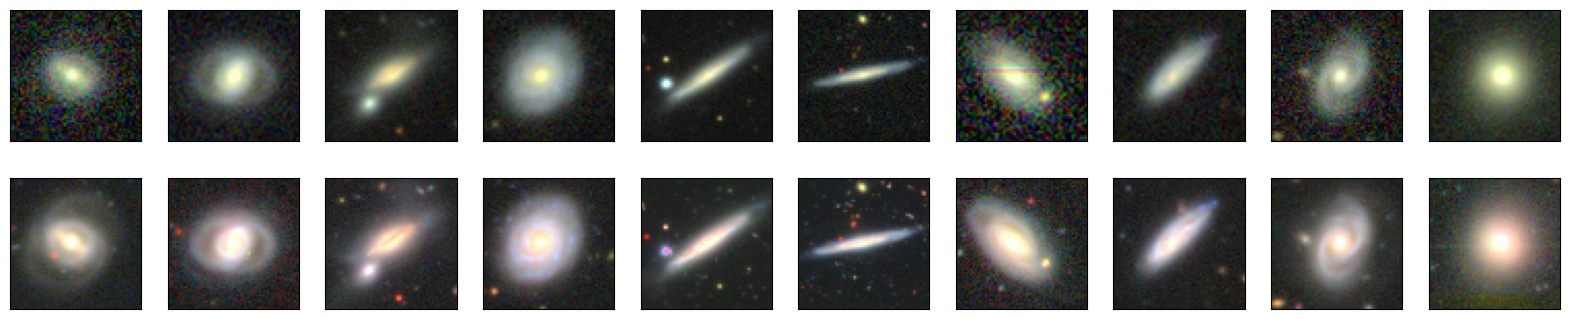

In [5]:
display_imgs(full_data.map(lambda x: x * 255), 10)

From there, we create the training and testing datasets from an extended dataset that includes horizontal and vertical mirrors of the images.

In [6]:
# Train-test split function
def train_test_split(ds, p_train: 0.8):
    """Split a dataset into training and testing datasets, with ``p_train`` being the proportion of training data."""

    # Determine train/test split size
    ds_size = len(ds)
    train_size = int(ds_size * p_train)
    test_size = int(ds_size * (1 - p_train))

    # Shuffle dataset
    rand_ds = ds.shuffle(min(3000, ds_size))

    # Split into "x" and "y" datasets
    img_size = tuple(ds.element_spec.shape[1:])
    x_train = np.empty((train_size, *img_size), dtype=np.float32)
    y_train = np.empty((train_size, *img_size), dtype=np.float32)
    x_test = np.empty((test_size, *img_size), dtype=np.float32)
    y_test = np.empty((test_size, *img_size), dtype=np.float32)

    ds_iter = rand_ds.as_numpy_iterator()

    for i in range(train_size):
        x_train[i], y_train[i] = next(ds_iter)

    for i in range(test_size):
        x_test[i], y_test[i] = next(ds_iter)

    return x_train, y_train, x_test, y_test

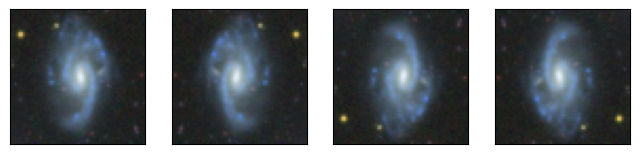

In [7]:
# Create datasets of flipped images
hor_data = full_data.map(tf.image.flip_left_right)
vert_data = full_data.map(tf.image.flip_up_down)
tp_data = hor_data.map(tf.image.flip_up_down)

# Plot results to confirm
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(8, 2)

image1 = next(full_data.as_numpy_iterator())[1] * 255
image2 = next(hor_data.as_numpy_iterator())[1] * 255
image3 = next(vert_data.as_numpy_iterator())[1] * 255
image4 = next(tp_data.as_numpy_iterator())[1] * 255

# Plot images
ax = axes[0]
ax.imshow(image1.astype("int32"))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = axes[1]
ax.imshow(image2.astype("int32"))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = axes[2]
ax.imshow(image3.astype("int32"))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = axes[3]
ax.imshow(image4.astype("int32"))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()


In [8]:
extended_data = full_data.concatenate(hor_data).concatenate(vert_data).concatenate(tp_data)
lr_train, hr_train, lr_test, hr_test = train_test_split(extended_data, 0.7)

We then create a callback function to visually show the progress of the VAE as it trains, producing a set of images at the end of each epoch.

In [9]:
def disp_pred_img(lr_ds, hr_ds, pred_ds, n_imgs = 5):
    """Plot the set of three matching images from a low resolution image dataset,
    a high resolution dataset, and a VAE predicted image dataset."""

    # Get matching images from dataset
    rand_ind = np.random.randint(0, len(lr_ds), (n_imgs))
    lr_imgs = lr_ds[rand_ind]
    hr_imgs = hr_ds[rand_ind]
    pred_imgs = pred_ds[rand_ind]

    fig, axes = plt.subplots(3, n_imgs)

    for i in range(n_imgs):

        lr_img = lr_imgs[i].astype("int32")
        axes[0, i].imshow(lr_img)
        axes[0, i].get_xaxis().set_visible(False)
        axes[0, i].get_yaxis().set_visible(False)

        hr_img = hr_imgs[i].astype("int32")
        axes[1, i].imshow(hr_img)
        axes[1, i].get_xaxis().set_visible(False)
        axes[1, i].get_yaxis().set_visible(False)

        pred_img = pred_imgs[i].astype("int32")
        axes[2, i].imshow(pred_img)
        axes[2, i].get_xaxis().set_visible(False)
        axes[2, i].get_yaxis().set_visible(False)

    plt.show()

# Create callback to plot generated images
class ImgGenCallback(keras.callbacks.Callback):
    def on_epoch_end(self, *args):

        n_imgs = 5

        rand_inds = np.random.randint(0, len(lr_train), (n_imgs + 5))
        lr_img_arr = lr_train[rand_inds]
        hr_img_arr = hr_train[rand_inds]
        pred_imgs = self.model.predict(lr_img_arr)

        disp_pred_img(lr_img_arr * 255, hr_img_arr * 255, pred_imgs * 255, 5)



We then create and train two VAEs:
- A relatively simple 8 layer VAE with roughly 30k parameters
- A more complex 8 layer VAE with roughly 300k parameters

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

input = layers.Input(shape=(64, 64, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
small_autoencoder = Model(input, x, name="Simple_VAE")
small_autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
small_autoencoder.summary()

Model: "Simple_VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,507 (115.26 KB)

 Trainable params: 29,507 (115.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/stepstep - loss: 0.579


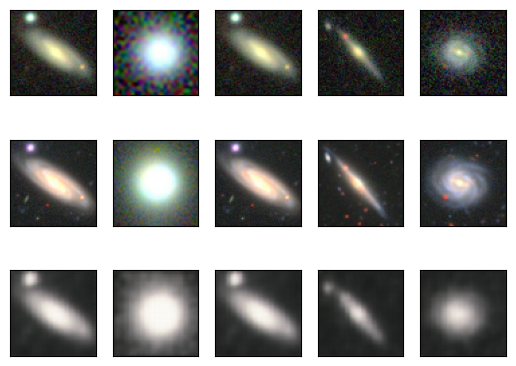

287/287 ━━━━━━━━━━━━━━━━━━━━ 59s 190ms/step - loss: 0.5795 - val_loss: 0.5262
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/stepstep - loss: 0.525


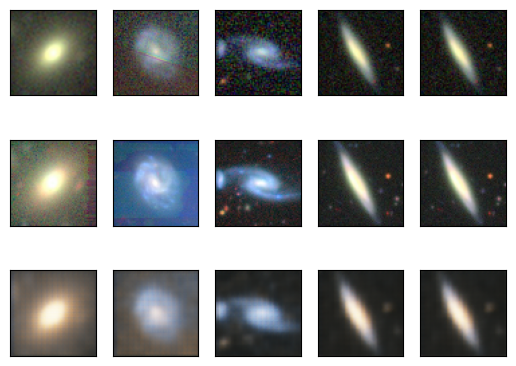

287/287 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - loss: 0.5252 - val_loss: 0.5234
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - loss: 0.522


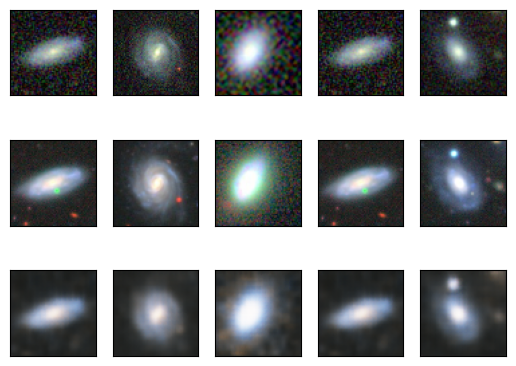

287/287 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - loss: 0.5223 - val_loss: 0.5225
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/stepstep - loss: 0.521


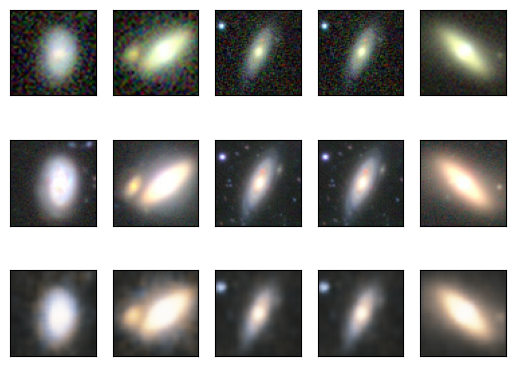

287/287 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - loss: 0.5219 - val_loss: 0.5223
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/stepstep - loss: 0.521


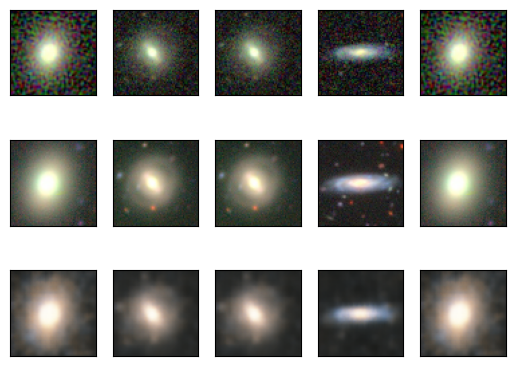

287/287 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - loss: 0.5217 - val_loss: 0.5221
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/stepstep - loss: 0.521


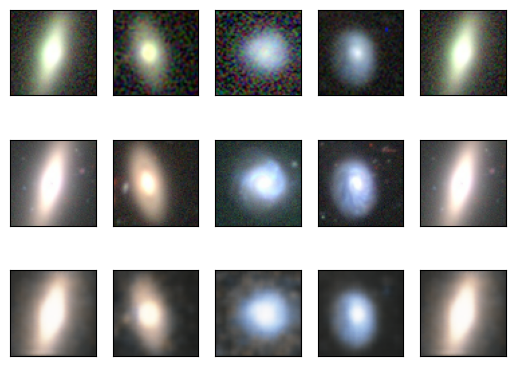

287/287 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - loss: 0.5215 - val_loss: 0.5220
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/stepstep - loss: 0.521


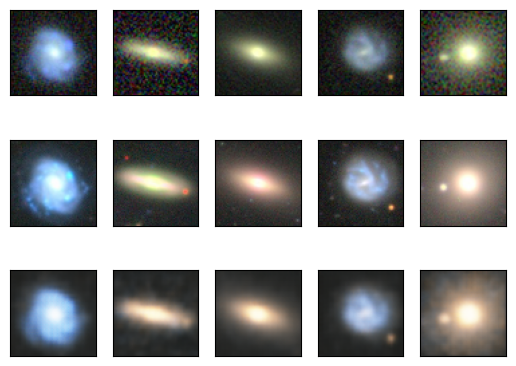

287/287 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - loss: 0.5214 - val_loss: 0.5219
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/stepstep - loss: 0.521


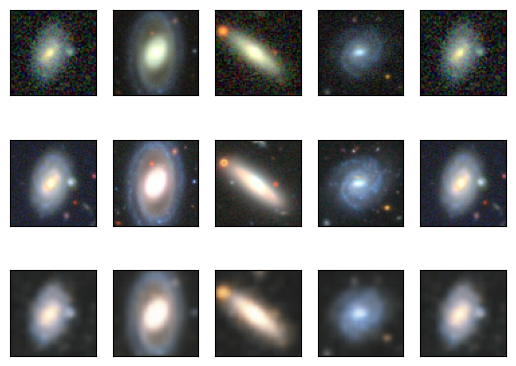

287/287 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - loss: 0.5214 - val_loss: 0.5221
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/stepstep - loss: 0.521


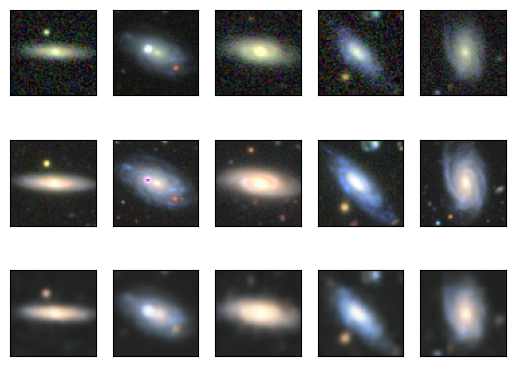

287/287 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - loss: 0.5214 - val_loss: 0.5218
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/stepstep - loss: 0.521


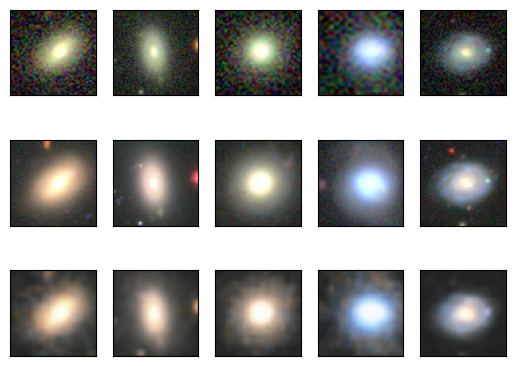

287/287 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - loss: 0.5212 - val_loss: 0.5218


In [11]:
history = small_autoencoder.fit(
    x=lr_train,
    y=hr_train,
    epochs=10,
    batch_size=64,
    shuffle=False,
    validation_data=(lr_test, hr_test),
    callbacks=[ImgGenCallback()]
)

In [12]:
input = layers.Input(shape=(64, 64, 3))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
large_autoencoder = Model(input, x, name="Complex_VAE")
large_autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
large_autoencoder.summary()

Model: "Complex_VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 298,755 (1.14 MB)

 Trainable params: 298,755 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/stepstep - loss: 0.55


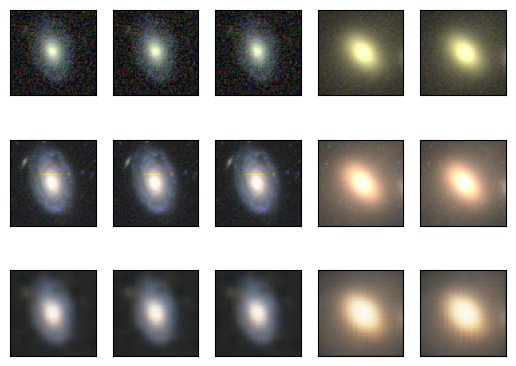

287/287 ━━━━━━━━━━━━━━━━━━━━ 136s 442ms/step - loss: 0.5593 - val_loss: 0.5231
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step/step - loss: 0.522


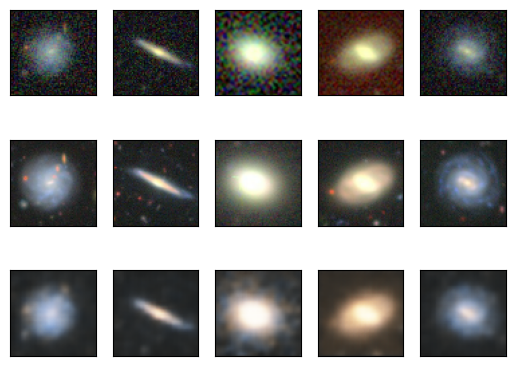

287/287 ━━━━━━━━━━━━━━━━━━━━ 96s 334ms/step - loss: 0.5223 - val_loss: 0.5224
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step/step - loss: 0.521


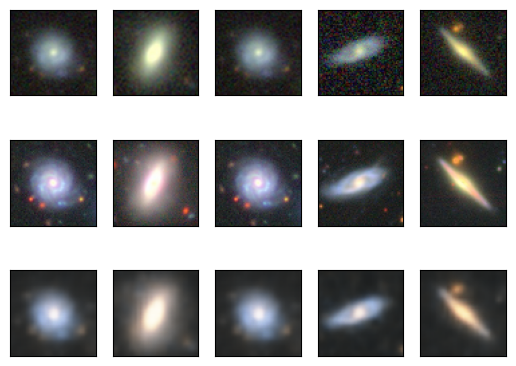

287/287 ━━━━━━━━━━━━━━━━━━━━ 94s 327ms/step - loss: 0.5216 - val_loss: 0.5220
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step/step - loss: 0.521


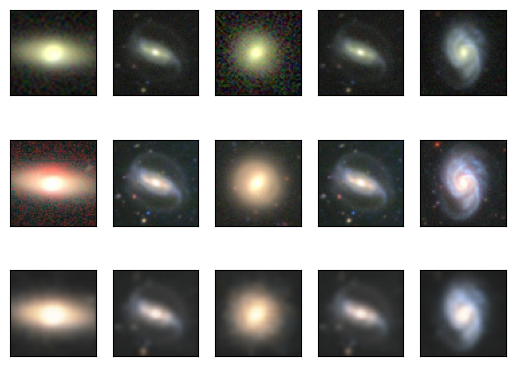

287/287 ━━━━━━━━━━━━━━━━━━━━ 101s 352ms/step - loss: 0.5212 - val_loss: 0.5217
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step/step - loss: 0.521


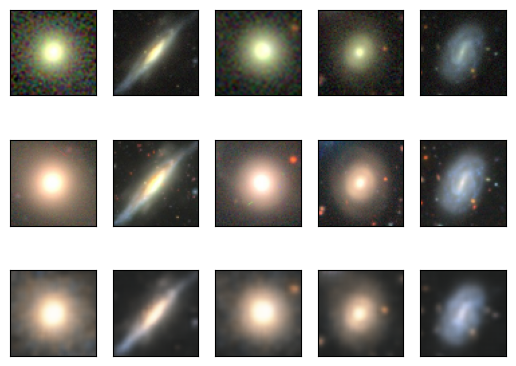

287/287 ━━━━━━━━━━━━━━━━━━━━ 93s 325ms/step - loss: 0.5210 - val_loss: 0.5215
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step/step - loss: 0.520


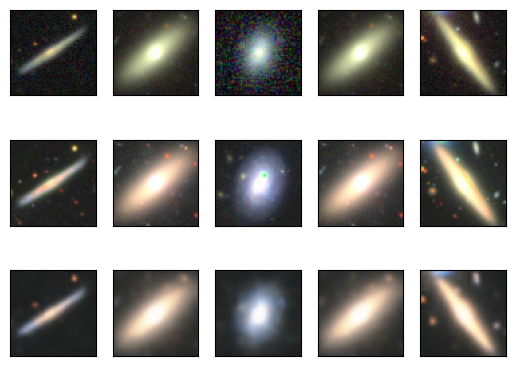

287/287 ━━━━━━━━━━━━━━━━━━━━ 90s 314ms/step - loss: 0.5209 - val_loss: 0.5214
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step/step - loss: 0.520


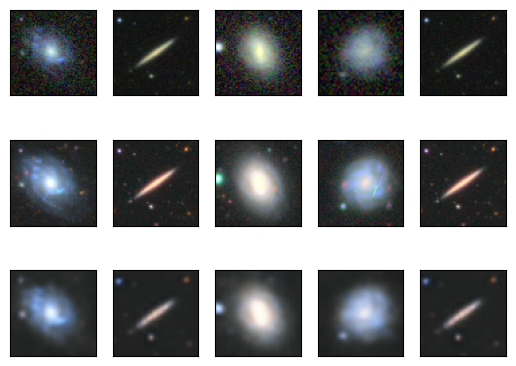

287/287 ━━━━━━━━━━━━━━━━━━━━ 91s 316ms/step - loss: 0.5208 - val_loss: 0.5217
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step/step - loss: 0.520


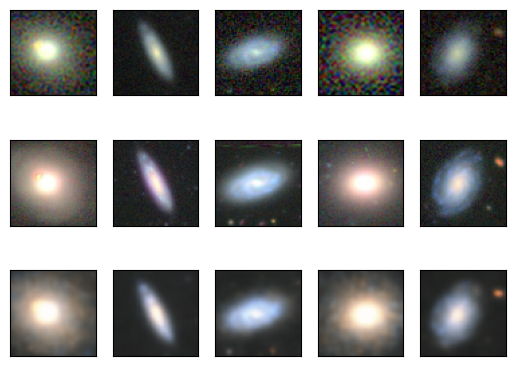

287/287 ━━━━━━━━━━━━━━━━━━━━ 100s 349ms/step - loss: 0.5208 - val_loss: 0.5214
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step/step - loss: 0.520


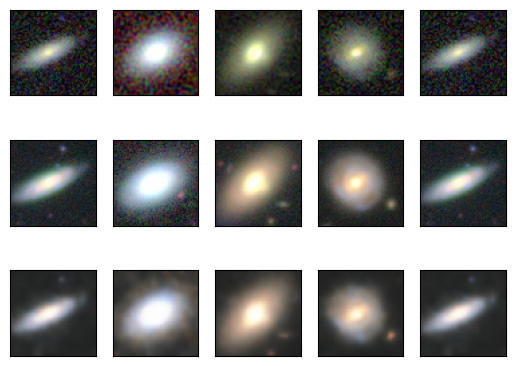

287/287 ━━━━━━━━━━━━━━━━━━━━ 100s 350ms/step - loss: 0.5207 - val_loss: 0.5213
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step/step - loss: 0.520


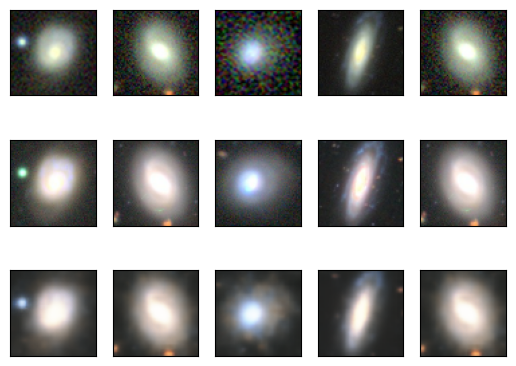

287/287 ━━━━━━━━━━━━━━━━━━━━ 123s 430ms/step - loss: 0.5206 - val_loss: 0.5212


In [13]:
history = large_autoencoder.fit(
    x=lr_train,
    y=hr_train,
    epochs=10,
    batch_size=64,
    shuffle=False,
    validation_data=(lr_test, hr_test),
    callbacks=[ImgGenCallback()]
)

As shown, the VAEs are able to upscale the lower resolution images to a similar quality as the higher reesolution images. To note though, the VAEs sometimes do not regain the specific color grading or intricate detail, such as the spiral structure.